# Practice: Statistical Significance

Let's say that we've collected data for a web-based experiment. In the experiment, we're testing the change in layout of a product information page to see if this affects the proportion of people who click on a button to go to the download page. This experiment has been designed to have a cookie-based diversion, and we record two things from each user: which page version they received, and whether or not they accessed the download page during the data recording period. (We aren't keeping track of any other factors in this example, such as number of pageviews, or time between accessing the page and making the download, that might be of further interest.)

Your objective in this notebook is to perform a statistical test on both recorded metrics to see if there is a statistical difference between the two groups.

In [3]:
# import packages

import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats import proportion as proptests

import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
# import data

data = pd.read_csv('../data/statistical_significance_data.csv')
data.head(10)

,condition,click
0,1,0
1,0,0
2,0,0
3,1,1
4,1,0
5,1,0
6,0,0
7,1,1
8,0,0
9,1,0


In the dataset, the 'condition' column takes a 0 for the control group, and 1 for the experimental group. The 'click' column takes a values of 0 for no click, and 1 for a click.

## Checking the Invariant Metric

First of all, we should check that the number of visitors assigned to each group is similar. It's important to check the invariant metrics as a prerequisite so that our inferences on the evaluation metrics are founded on solid ground. If we find that the two groups are imbalanced on the invariant metric, then this will require us to look carefully at how the visitors were split so that any sources of bias are accounted for. It's possible that a statistically significant difference in an invariant metric will require us to revise random assignment procedures and re-do data collection.

In this case, we want to do a two-sided hypothesis test on the proportion of visitors assigned to one of our conditions. Choosing the control or the experimental condition doesn't matter: you'll get the same result either way. Feel free to use whatever method you'd like: we'll highlight two main avenues below.

If you want to take a simulation-based approach, you can simulate the number of visitors that would be assigned to each group for the number of total observations, assuming that we have an expected 50/50 split. Do this many times (200 000 repetitions should provide a good speed-variability balance in this case) and then see in how many simulated cases we get as extreme or more extreme a deviation from 50/50 that we actually observed. Don't forget that, since we have a two-sided test, an extreme case also includes values on the opposite side of 50/50. (e.g. Since simulated outcomes of .48 and lower are considered as being more extreme than an actual observation of 0.48, so too will simulated outcomes of .52 and higher.) The proportion of flagged simulation outcomes gives us a p-value on which to assess our observed proportion. We hope to see a larger p-value, insufficient evidence to reject the null hypothesis.

If you want to take an analytic approach, you could use the exact binomial distribution to compute a p-value for the test. The more usual approach, however, is to use the normal distribution approximation. Recall that this is possible thanks to our large sample size and the central limit theorem. To get a precise p-value, you should also perform a 
continuity correction, either adding or subtracting 0.5 to the total count before computing the area underneath the curve. (e.g. If we had 415 / 850 assigned to the control group, then the normal approximation would take the area to the left of $(415 + 0.5) / 850 = 0.489$ and to the right of $(435 - 0.5) / 850 = 0.511$.)

You can check your results by completing the quiz and watching the video following the workspace. You could also try using multiple approaches and seeing if they come up with similar outcomes!

### Analytic Approach

In [9]:
data.groupby('condition').size()

condition
0    491
1    508
dtype: int64

In [4]:
# get number of trials and number of 'successes'
n_obs = data.shape[0]
n_control = data.groupby('condition').size()[0]

In [6]:
n_control

491

In [4]:
# Compute a z-score and p-value
p = 0.5
sd = np.sqrt(p * (1-p) * n_obs)

z = ((n_control + 0.5) - p * n_obs) / sd

print(z)
print(2 * stats.norm.cdf(z))

-0.506217597735
0.612703902554


### Simulation Approach

In [5]:
# get number of trials and number of 'successes'
n_obs = data.shape[0]
n_control = data.groupby('condition').size()[0]

In [6]:
# # simulate outcomes under null, compare to observed outcome
p = 0.5
n_trials = 200_000

samples = np.random.binomial(n_obs, p, n_trials)

print(np.logical_or(samples <= n_control, samples >= (n_obs - n_control)).mean())

0.61229


## Checking the Evaluation Metric

After performing our checks on the invariant metric, we can move on to performing a hypothesis test on the evaluation metric: the click-through rate. In this case, we want to see that the experimental group has a significantly larger click-through rate than the control group, a one-tailed test.

The simulation approach for this metric isn't too different from the approach for the invariant metric. You'll need the overall click-through rate as the common proportion to draw simulated values from for each group. You may also want to perform more simulations since there's higher variance for this test.

There's a few analytic approaches possible here, but you'll probably make use of the normal approximation again in these cases. In addition to the pooled click-through rate, you'll need a pooled standard deviation in order to compute a z-score. While there is a continuity correction possible in this case as well, it's much more conservative than the p-value that a simulation will usually imply. Computing the z-score and resulting p-value without a continuity correction should be closer to the simulation's outcomes, though slightly more optimistic about there being a statistical difference between groups.

As with the previous question, you'll find a quiz and video following the workspace for you to check your results.

In [66]:
p_click = data.groupby('condition').mean()['click']
p_click

condition
0    0.079430
1    0.112205
Name: click, dtype: float64

In [8]:
p_click[1] - p_click[0]

0.03277498917523293

### Self Exploration

In [5]:
# Created separate Control & experimental groups
cont_grp = data.query("condition == 0")  # Control Group
exp_grp = data.query("condition == 1")  # Experimental Group

In [6]:
# Calculated CTR of Control Group
control_ctr = cont_grp.query("click == 1").shape[0] / cont_grp.query("click == 0").shape[0] 
control_ctr

0.08628318584070796

In [7]:
# CTR for Experimental Group
exp_ctr = exp_grp.query("click == 1").shape[0] / exp_grp.query("click == 0").shape[0] 
exp_ctr

0.12638580931263857

##### Experimental group has  slightly larger .4% CTR rate than Control group

In [8]:
# Difference in Proportion
obs_diff = exp_ctr - control_ctr
obs_diff

0.04010262347193061

In [9]:
# Simulated the sampling distribution for the difference in proportions
diff = []

for _ in range(10000):
    samp = data.sample(data.shape[0], replace=True)
    cont_grp = samp.query("condition == 0")
    exp_grp = samp.query("condition == 1")
    control_ctr = cont_grp.query("click == 1").shape[0] / cont_grp.query("click == 0").shape[0]
    exp_ctr = exp_grp.query("click == 1").shape[0] / exp_grp.query("click == 0").shape[0]
    diff.append(exp_ctr - control_ctr)

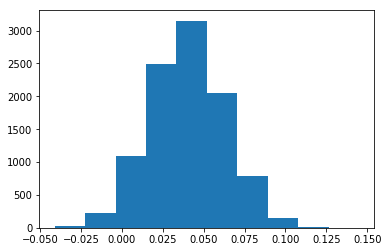

In [10]:
plt.hist(diff);

##### We used this sampling distribution to simulate the distribution under the null hypothesis, by creating a random normal distribution centered at 0 with the same spread and size.

In [11]:
diffs = np.array(diff)
null_vals = np.random.normal(0, diffs.std(), diffs.size)

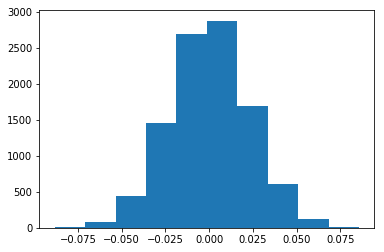

In [12]:
plt.hist(null_vals);

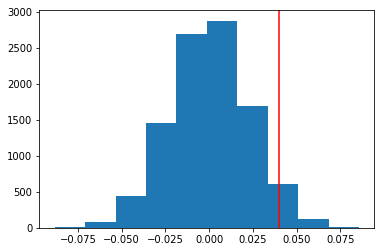

In [13]:
plt.hist(null_vals);
plt.axvline(x=obs_diff,color='red');

In [14]:
(null_vals > obs_diff).mean() # Finding the p-value

0.042900000000000001

##### My Conclusion: We find out p-value which is less than our significance level( let's say 5%=0.5) . So, we can say that the difference in the proportion of CTR of control & experiment group is significant and we should REJECT the Null hypothesis & should continue to launching the new feature.

### Analytic Approach

In [11]:
cont = data.groupby('condition').size()[0]
exp = data.groupby('condition').size()[1]

In [37]:
# get number of trials and overall 'success' rate under null
n_control = data.groupby('condition').size()[0]
n_exper = data.groupby('condition').size()[1]
p_null = data['click'].mean()

In [39]:
p_null # overall 'success' rate under null

0.096096096096096095

In [83]:
# compute standard error, z-score, and p-value
se_p = np.sqrt(p_null * (1-p_null) * (1/n_control + 1/n_exper))

z = (p_click[1] - p_click[0]) / se_p
print(z)
print(1-stats.norm.cdf(z))

1.75718873962
0.0394428219746


### Simulation Approach

In [57]:
# get number of trials and overall 'success' rate under null
n_control = data.groupby('condition').size()[0]
n_exper = data.groupby('condition').size()[1]
p_null = data['click'].mean()
p_null

0.096096096096096095

In [79]:
# simulate outcomes under null, compare to observed outcome
n_trials = 200_000

ctrl_clicks = np.random.binomial(n_control, p_null, n_trials)
exp_clicks = np.random.binomial(n_exper, p_null, n_trials)
samples = exp_clicks / n_exper - ctrl_clicks / n_control

print((samples >= (p_click[1] - p_click[0])).mean())

0.04059
